In [147]:
#import dependencies and sqlalchemy 

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import datetime as dt
import json 
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect, distinct, desc, select


In [148]:
#create engine to connect to database
engine = create_engine("sqlite:///_HI.sqlite")
connection = engine.connect()

In [149]:
#verify tables via inspector
inspector = inspect(engine)
inspector.get_table_names()

['measurements', 'stations']

In [150]:
#declare a base
Base = automap_base()

In [151]:
Base.prepare(engine, reflect=True)

In [152]:
Base.classes.keys()

['measurements', 'stations']

In [153]:
#assign variables for the classes
measurements = Base.classes.measurements
stations = Base.classes.stations

In [154]:
#create a session
session = Session(engine)

In [155]:
#inspect 'measurements'
columns = inspector.get_columns('measurements')
for column in columns:
    print(column["name"], column["type"])

id INTEGER
station VARCHAR
date VARCHAR
prcp FLOAT
tobs INTEGER


In [156]:
#inspect 'stations'
columns = inspector.get_columns('stations')
for column in columns:
    print(column["name"], column["type"])

id INTEGER
station VARCHAR
name VARCHAR
latitude FLOAT
longitude FLOAT
elevation FLOAT


## Precipitation Analysis

In [157]:
# precipitation values list
prcp_list = session.query(measurements.prcp).\
group_by(measurements.date).\
order_by(desc(measurements.date)).limit(365).all()


In [158]:
# Precipitation Date List
prcp_date_list = session.query(measurements.date).\
group_by(measurements.date).\
order_by(desc(measurements.date)).limit(365).all()



In [159]:
initial_prcp_df = pd.DataFrame(prcp_date_list).join(pd.DataFrame(prcp_list))
prcp_df = initial_prcp_df.set_index('date')
prcp_df.head(5)

,prcp
date,
2017-08-23,0.45
2017-08-22,0.50
2017-08-21,0.56
2017-08-20,0.01
2017-08-19,0.09


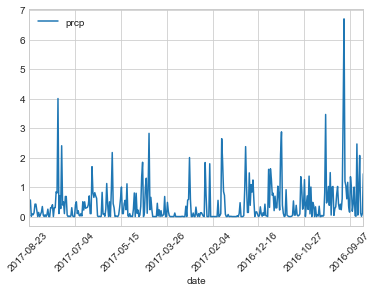

In [160]:
prcp_df.reset_index().plot(x='date', y='prcp')
plt.xticks(rotation=45)
plt.show()

## Station Analysis

In [161]:
#design a query to calculate the total number of stations

session.query(func.count(distinct(measurements.station))).all()

[(9)]

In [162]:
#design a query to find the most active stations
active = session.query(measurements.station,
    func.count(measurements.station).label('qty')
    ).group_by(measurements.station
    ).order_by(desc('qty')).all()
active

[('USC00519281', 2772),
 ('USC00513117', 2696),
 ('USC00519397', 2685),
 ('USC00519523', 2572),
 ('USC00516128', 2484),
 ('USC00514830', 1937),
 ('USC00511918', 1932),
 ('USC00517948', 683),
 ('USC00518838', 342)]

In [163]:
# temperatures values list filtered by station with highest number of observations
temp_list = session.query(measurements.tobs).\
filter_by(station='USC00519281').\
group_by(measurements.date).\
order_by(desc(measurements.date)).limit(365).all()

In [164]:
# Temperature Date List 
temp_date_list = session.query(measurements.date).\
group_by(measurements.date).\
order_by(desc(measurements.date)).limit(365).all()

In [165]:
initial_tobs_df = pd.DataFrame(temp_date_list).join(pd.DataFrame(temp_list))
temp_df = initial_tobs_df.set_index('date')
temp_df.head()

,tobs
date,
2017-08-23,79
2017-08-22,76
2017-08-21,76
2017-08-20,77
2017-08-19,77


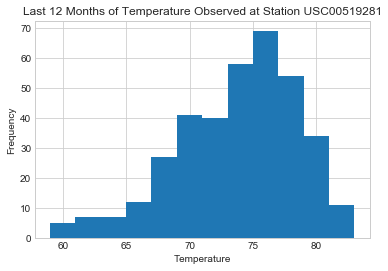

In [166]:
#results plotted as histogram
hist_plot = temp_df['tobs'].hist(bins=12)
hist_plot.set_title('Last 12 Months of Temperature Observed at Station USC00519281')
hist_plot.set_xlabel('Temperature')
hist_plot.set_ylabel('Frequency')
plt.show()

# Temperture Analysis

In [167]:
#choose dates for vacation
start_date = dt.date(2018,7,1)
end_date = dt.date(2018,7,6)
print(start_date)
print(end_date)

2018-07-01
2018-07-06


In [168]:
#define variables that show start date and end date for one year prior to my trip
year_ago_start = start_date - dt.timedelta(days=365)
year_ago_end = end_date -dt.timedelta(days=365)
print(year_ago_start)
print(year_ago_end)

2017-07-01
2017-07-06


In [169]:
# Use the calc_temps function to calculate the min, avg, and max temperatures for your trip using the matching dates
#from the previous year (i.e. use "2017-01-01" if your trip start date was "2018-01-01")

sel = [measurements.date, func.min(measurements.tobs), func.avg(measurements.tobs), func.max(measurements.tobs)]




In [170]:
calc_temps = session.query(*sel).\
    filter(measurements.date >= year_ago_start).\
    filter(measurements.date <= year_ago_end).\
    group_by(measurements.date).\
    order_by(measurements.tobs).all()
calc_temps

[('2017-07-01', 74, 77.25, 80),
 ('2017-07-04', 77, 78.0, 80),
 ('2017-07-05', 75, 77.25, 80),
 ('2017-07-02', 77, 79.0, 81),
 ('2017-07-03', 76, 77.8, 81),
 ('2017-07-06', 74, 76.8, 81)]

In [171]:
trip_df = pd.DataFrame(calc_temps, columns= ["dates", "temp_min", "temp_avg", "temp_max"])
trip_df.set_index('dates', inplace=True)
trip_df

,temp_min,temp_avg,temp_max
dates,,,
2017-07-01,74,77.25,80
2017-07-04,77,78.00,80
2017-07-05,75,77.25,80
2017-07-02,77,79.00,81
2017-07-03,76,77.80,81
2017-07-06,74,76.80,81


In [172]:
#find the average temperture for trip range
avg_trip_df = [trip_df["temp_avg"].mean()]
avg_trip_df

[77.68333333333334]

In [173]:
min_trip_df = trip_df["temp_min"].min()
min_trip_df

74

In [174]:
max_trip_df = trip_df["temp_max"].max()
max_trip_df

81

In [175]:
peak_to_peak = [max_trip_df - min_trip_df]
peak_to_peak

[7]

In [213]:
x_axis = ["7/1/17 - 7/6/17"]
y_axis = avg_trip_df

ind = np.arange(len(x_axis))
ind


array([0])

(0, 100)

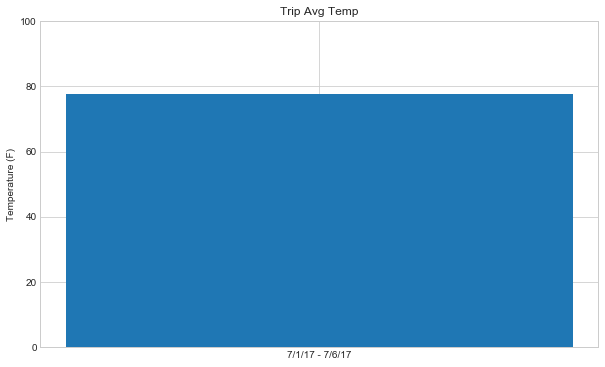

In [216]:
plt.bar(ind, y_axis)
plt.xticks(ind, x_axis)
ax = plt.gca()
ax.set(title='Trip Avg Temp', ylabel='Temperature (F)')
plt.ylim((0,100))


